## Load-in dependencies:

In [1]:
using Pkg
# Pkg.add("Profile")
# Pkg.instantiate()

In [2]:
#= dependencies = ["DelimitedFiles", "LinearAlgebra", "Optim", "Distributions", "Test",
                "BenchmarkTools", "Random", "CSV", "DataFrames", "Distributed", "Plots"];
Pkg.add(dependencies) =#

In [3]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Plots
using Profile
using Distributed

In [4]:
pwd()

"/home/xyu/github/BulkLMM.jl/analysis"

In [5]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");
include("../src/scan_for_tests.jl")
include("../src/scan_distributed.jl") # new function

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

## Read in BXD data:

In [6]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [7]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

In [8]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [9]:
# Pkg.add("StatsBase")

In [10]:
using StatsBase

In [11]:
n_seeds = 20;

In [12]:
seeds_list = StatsBase.sample(1:100, n_seeds; replace = false)

20-element Vector{Int64}:
 14
 60
 11
 81
 15
 36
 62
 41
 90
 99
 16
 80
 59
 40
 26
 50
 49
  7
 25
 31

## Three phases of data transformations:

In [13]:
(y0, X0, lambda0) = transform1(pheno_y, geno, kinship);

In [14]:
# unique(round.(lambda0; digits = 3))

In [15]:
(r0, X00) = transform2(y0, X0, lambda0; reml = false);

## Study: distribute over permutations

### Check results:

Will the results be consistent, if we fixed the set of rotated data for further algorithm?

In [16]:
map_results = map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
map_LODs = reduce(vcat, map_results);

In [17]:
using Distributed

In [105]:
addprocs(2);

In [19]:
# procs()

In [20]:
# rmprocs(collect(1:8))

In [21]:
procs()

9-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [106]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using Distributed
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [23]:
pmap_results = pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
pmap_LODs = reduce(vcat, pmap_results);

In [24]:
size(pmap_LODs)

(2000, 7321)

In [25]:
pmap_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.165284    0.165284    0.165284    0.165284    0.165284    0.165284
 0.123089    0.123089    0.123089    0.123089    0.123089    0.123089
 0.976772    0.976772    0.976772    0.976772    0.976772    0.976772
 0.0388744   0.0388744   0.0388744   0.0388744   0.0388744   0.0388744
 7.36844e-5  7.36844e-5  7.36844e-5  7.36844e-5  7.36844e-5  7.36844e-5
 0.0812383   0.0812383   0.0812383   0.0812383   0.0812383   0.0812383

In [26]:
map_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.165284    0.165284    0.165284    0.165284    0.165284    0.165284
 0.123089    0.123089    0.123089    0.123089    0.123089    0.123089
 0.976772    0.976772    0.976772    0.976772    0.976772    0.976772
 0.0388744   0.0388744   0.0388744   0.0388744   0.0388744   0.0388744
 7.36844e-5  7.36844e-5  7.36844e-5  7.36844e-5  7.36844e-5  7.36844e-5
 0.0812383   0.0812383   0.0812383   0.0812383   0.0812383   0.0812383

In [27]:
maxSqDiff(map_LODs, pmap_LODs) 

0.0

It turned out that if we give the same set of rotated data, results will match, which implies that the inconsistency of results may only be due to the rotation process (sign ambiguity in eigendecomposition).

### Benchmarking:

map(permutations)

In [28]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.956 s …   4.983 s  ┊ GC (min … max): 4.74% … 4.18%
 Time  (median):     4.969 s              ┊ GC (median):    4.46%
 Time  (mean ± σ):   4.969 s ± 18.865 ms  ┊ GC (mean ± σ):  4.46% ± 0.40%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  4.96 s         Histogram: frequency by time        4.98 s <

 Memory estimate: 26.95 GiB, allocs estimate: 1474363.

pmap(permutations)

In [29]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.035 s …    1.303 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.233 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.174 s ± 126.347 ms  ┊ GC (mean ± σ):  0.44% ± 1.11%

  ██                                        █     █        █  
  ██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁█ ▁
  1.03 s         Histogram: frequency by time          1.3 s <

 Memory estimate: 120.79 MiB, allocs estimate: 2163.

In [30]:
@benchmark map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.797 s …   4.862 s  ┊ GC (min … max): 4.48% … 4.69%
 Time  (median):     4.829 s              ┊ GC (median):    4.58%
 Time  (mean ± σ):   4.829 s ± 45.881 ms  ┊ GC (mean ± σ):  4.58% ± 0.15%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  4.8 s          Histogram: frequency by time        4.86 s <

 Memory estimate: 26.94 GiB, allocs estimate: 1474342.

In [31]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 50, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  511.293 ms … 826.507 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     670.361 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   658.623 ms ± 118.541 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █   █ █                    █      █          █   █          █  
  █▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁█ ▁
  511 ms           Histogram: frequency by time          827 ms <

 Memory estimate: 55.92 MiB, allocs estimate: 1663.

## Study: distribute over markers

### Check results:

In [32]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [33]:
size(r0perm) 
# 401 permutations of a vector of length 79 (79 measurements), plus the original, for results checking with scan_null

(79, 1001)

In [34]:
map_eachMarker_LODs = map(x -> scan_distributed(r0perm, X00, x), 1:7321);
map_eachMarker_LODs = reduce(vcat, map_eachMarker_LODs);

In [35]:
pmap_eachMarker_LODs = pmap(x -> scan_distributed(r0perm, X00, x), 1:7321);
pmap_eachMarker_LODs = reduce(vcat, pmap_eachMarker_LODs);

In [36]:
scan_null_original = scan(pheno_y, geno, kinship)[3]; # original trait vector LODs

In [37]:
map_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [38]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [39]:
scan_null_original[1:6]

6-element Vector{Float64}:
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583

In [40]:
maxSqDiff(map_eachMarker_LODs, pmap_eachMarker_LODs)

7.888609052210118e-29

In [41]:
maxSqDiff(reshape(pmap_eachMarker_LODs[:, 1], :, 1), reshape(scan_null_original, :, 1))

3.077050568427709e-28

In [42]:
disLoops_LODs = scan_distributed(r0perm, X00);

In [43]:
disLoops_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [44]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [45]:
permutedims(scan_perms2(pheno_y, geno, kinship; nperms = 400, rndseed = 0, original = true))[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

### Benchmarking:

In [46]:
@benchmark map(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.531 s …   2.546 s  ┊ GC (min … max): 3.15% … 3.25%
 Time  (median):     2.539 s              ┊ GC (median):    3.20%
 Time  (mean ± σ):   2.539 s ± 10.578 ms  ┊ GC (mean ± σ):  3.20% ± 0.07%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.53 s         Histogram: frequency by time        2.55 s <

 Memory estimate: 13.29 GiB, allocs estimate: 109817.

In [47]:
@benchmark pmap(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 9.476 s (0.00% GC) to evaluate,
 with a memory estimate of 77.23 MiB, over 485338 allocations.

In [48]:
@benchmark scan_distributed(r0perm, X00) # using distributed loops for each marker

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.760 s …   1.937 s  ┊ GC (min … max): 0.33% … 0.00%
 Time  (median):     1.824 s              ┊ GC (median):    0.30%
 Time  (mean ± σ):   1.840 s ± 89.220 ms  ┊ GC (mean ± σ):  0.21% ± 0.18%

  █                   █                                   █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.76 s         Histogram: frequency by time        1.94 s <

 Memory estimate: 412.41 MiB, allocs estimate: 1212.

In [49]:
 # using ordinary loops for each marker
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 1000, original = true, rndseed = 0)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.502 s …   2.565 s  ┊ GC (min … max): 2.79% … 3.68%
 Time  (median):     2.534 s              ┊ GC (median):    3.24%
 Time  (mean ± σ):   2.534 s ± 44.585 ms  ┊ GC (mean ± σ):  3.24% ± 0.63%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.5 s          Histogram: frequency by time        2.57 s <

 Memory estimate: 13.30 GiB, allocs estimate: 74635.

In [50]:
range = 1:6;
typeof(range)

UnitRange{Int64}

## Study: distribute over blocks of markers

### Check results:

In [51]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [52]:
permutedims(scan_distributed_block(r0perm, X00, 1:6))[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [53]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [54]:
## https://stackoverflow.com/questions/26953340/partition-equivalent-in-julia

function partition_array_indices(nb_data::Int, nb_data_per_chunk::Int)
    nb_chunks = ceil(Int, nb_data / nb_data_per_chunk)
    ids = UnitRange{Int}[]
    for which_chunk = 1:nb_chunks
        id_start::Int = 1 + nb_data_per_chunk * (which_chunk - 1)
        id_end::Int = id_start - 1 + nb_data_per_chunk
        if id_end > nb_data
            id_end = nb_data
        end
        push!(ids, id_start:id_end)
    end
    return ids
end

partition_array_indices (generic function with 1 method)

In [55]:
blocks_partitions = partition_array_indices(p, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [56]:
map_blocks_LODs = map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
map_blocks_LODs = permutedims(reduce(hcat, map_blocks_LODs));

In [57]:
map_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [58]:
pmap_blocks_LODs = pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
pmap_blocks_LODs = permutedims(reduce(hcat, pmap_blocks_LODs));

In [59]:
pmap_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [60]:
normal_LODs = scan_perms2(pheno_y, geno, kinship; nperms = 1000, rndseed = 0, original = true);
normal_LODs = permutedims(normal_LODs);

In [61]:
normal_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [62]:
maxSqDiff(pmap_blocks_LODs, normal_LODs)

7.888609052210118e-29

### Benchmarking:

In [63]:
blocks_partitions

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [64]:
@benchmark map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.548 s …   2.669 s  ┊ GC (min … max): 2.68% … 3.01%
 Time  (median):     2.608 s              ┊ GC (median):    2.85%
 Time  (mean ± σ):   2.608 s ± 85.991 ms  ┊ GC (mean ± σ):  2.85% ± 0.23%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.55 s         Histogram: frequency by time        2.67 s <

 Memory estimate: 13.27 GiB, allocs estimate: 73284.

In [65]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  462.300 ms … 766.310 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     712.439 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   689.057 ms ±  95.815 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                           █  █ ███       ██  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁█▁███▁▁▁▁▁▁▁██ ▁
  462 ms           Histogram: frequency by time          766 ms <

 Memory estimate: 55.95 MiB, allocs estimate: 1044.

In [66]:
@benchmark begin 
    transform1(pheno_y, geno, kinship);
    transform2(y0, X0, lambda0);
    pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
end

BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  479.486 ms … 774.949 ms  ┊ GC (min … max): 0.00% … 0.49%
 Time  (median):     740.915 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   662.214 ms ± 130.563 ms  ┊ GC (mean ± σ):  0.07% ± 0.17%

  ▁     ▁  ▁                                           ▁▁ ▁   █  
  █▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁█▁▁▁█ ▁
  479 ms           Histogram: frequency by time          775 ms <

 Memory estimate: 82.86 MiB, allocs estimate: 1275.

In [67]:
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 1000, rndseed = 0, original = true)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.498 s …   2.593 s  ┊ GC (min … max): 2.66% … 2.61%
 Time  (median):     2.545 s              ┊ GC (median):    2.64%
 Time  (mean ± σ):   2.545 s ± 67.386 ms  ┊ GC (mean ± σ):  2.64% ± 0.03%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.5 s          Histogram: frequency by time        2.59 s <

 Memory estimate: 13.30 GiB, allocs estimate: 74635.

In [68]:
seeds_list

20-element Vector{Int64}:
 14
 60
 11
 81
 15
 36
 62
 41
 90
 99
 16
 80
 59
 40
 26
 50
 49
  7
 25
 31

In [69]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 50, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  523.233 ms … 802.426 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     549.232 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   625.690 ms ± 115.921 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █  █ ▁                   ▁                        ▁▁        ▁  
  █▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁█ ▁
  523 ms           Histogram: frequency by time          802 ms <

 Memory estimate: 55.92 MiB, allocs estimate: 1680.

## Compare times for different choices of nperms and block sizes:

In [110]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = false);

In [111]:
@everywhere nperms_list = [50, 100, 200, 500, 1000];
@everywhere bsizes_list = [100, 300, 500, 600, 1000];
@everywhere nblocks_list = [10, 20, 30, 40, 80, 90, 100];

In [112]:
runtimes_nperms = Array{Float64, 1}(undef, length(nperms_list));
runtimes_bsizes = Array{Float64, 1}(undef, length(bsizes_list));
runtimes_nblocks = Array{Float64, 1}(undef, length(nblocks_list));

In [113]:
procs() # check number of procs active rn

11-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11

In [74]:
for i in 1:length(nperms_list)
    
    np = nperms_list[i];
    nseeds = Int(1000/np);
    
    seeds_list = StatsBase.sample(1:100, nseeds; replace = false)
    b = @benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = $np, rndseed = x, original = false), seeds_list);
    b = median(b)
    
    runtimes_nperms[i] = time(b)/1e9
    
end

In [75]:
for i in 1:length(bsizes_list)
    
    bs = bsizes_list[i];
    
    blocks_partitions = partition_array_indices(p, bs);

    
    b = @benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
    b = median(b)
    
    runtimes_bsizes[i] = time(b)/1e9
    
end

In [114]:
for i in 1:length(nblocks_list)
    
    bs = Int(ceil(p/nblocks_list[i]));
    
    blocks_partitions = partition_array_indices(p, bs);

    
    b = @benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
    b = median(b)
    
    runtimes_nblocks[i] = time(b)/1e9
    
end

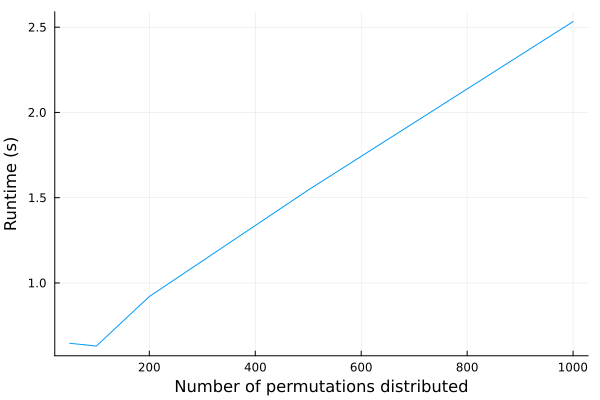

In [77]:
plot(nperms_list, runtimes_nperms; xlabel = "Number of permutations distributed", ylabel = "Runtime (s)", legend = false)

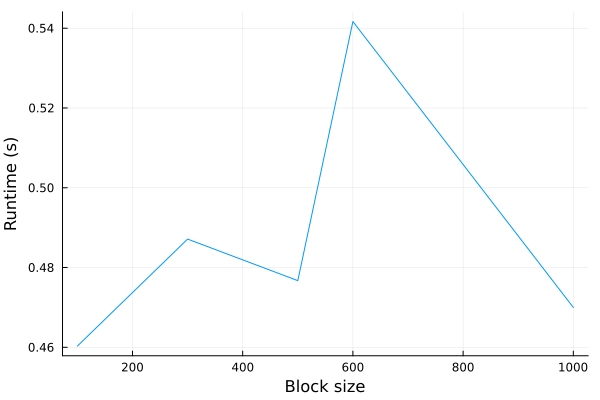

In [78]:
plot(bsizes_list, runtimes_bsizes; xlabel= "Block size", ylabel = "Runtime (s)", legend = false)

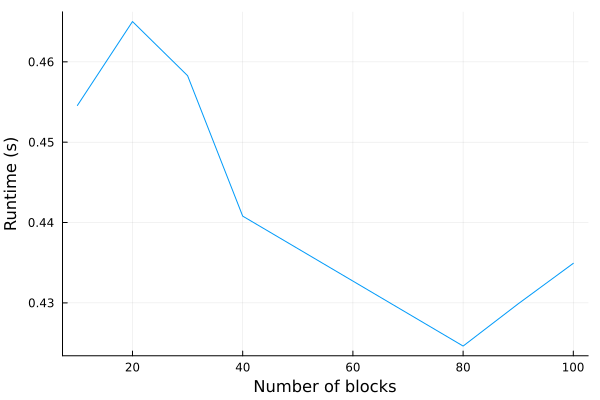

In [116]:
plot(nblocks_list, runtimes_nblocks; xlabel= "Number of blocks", ylabel = "Runtime (s)", legend = false)

By specifying the number of blocks needed...

In [119]:
bs = Int(ceil(p/20));
blocks_partitions = partition_array_indices(p, bs)

20-element Vector{UnitRange{Int64}}:
 1:367
 368:734
 735:1101
 1102:1468
 1469:1835
 1836:2202
 2203:2569
 2570:2936
 2937:3303
 3304:3670
 3671:4037
 4038:4404
 4405:4771
 4772:5138
 5139:5505
 5506:5872
 5873:6239
 6240:6606
 6607:6973
 6974:7321

In [120]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 9 samples with 1 evaluation.
 Range (min … max):  456.133 ms … 721.516 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     559.016 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   563.718 ms ± 105.480 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                           ▃  
  █▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▇▁▁▁▁▇▁▁▁▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  456 ms           Histogram: frequency by time          722 ms <

 Memory estimate: 55.93 MiB, allocs estimate: 1898.

In [82]:
nblocks = 140;
blocks_partitions = partition_array_indices(p, Int(floor(p/nblocks)))

141-element Vector{UnitRange{Int64}}:
 1:52
 53:104
 105:156
 157:208
 209:260
 261:312
 313:364
 365:416
 417:468
 469:520
 521:572
 573:624
 625:676
 ⋮
 6709:6760
 6761:6812
 6813:6864
 6865:6916
 6917:6968
 6969:7020
 7021:7072
 7073:7124
 7125:7176
 7177:7228
 7229:7280
 7281:7321

In [83]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  463.442 ms … 472.534 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     467.622 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   467.717 ms ±   2.425 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █         █       █     ██  █   █  █  █ █                   █  
  █▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁██▁▁█▁▁▁█▁▁█▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  463 ms           Histogram: frequency by time          473 ms <

 Memory estimate: 56.31 MiB, allocs estimate: 11480.

In [84]:
nblocks = 200;
blocks_partitions = partition_array_indices(p, Int(floor(p/nblocks)))

204-element Vector{UnitRange{Int64}}:
 1:36
 37:72
 73:108
 109:144
 145:180
 181:216
 217:252
 253:288
 289:324
 325:360
 361:396
 397:432
 433:468
 ⋮
 6913:6948
 6949:6984
 6985:7020
 7021:7056
 7057:7092
 7093:7128
 7129:7164
 7165:7200
 7201:7236
 7237:7272
 7273:7308
 7309:7321

In [85]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  493.522 ms … 563.766 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     533.823 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   530.495 ms ±  30.482 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █   ▁    ▁                     ▁      ▁                  ▁▁▁▁  
  █▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████ ▁
  494 ms           Histogram: frequency by time          564 ms <

 Memory estimate: 56.47 MiB, allocs estimate: 15315.

In [86]:
Int(floor(p/10))

732

In [87]:
partition_array_indices(p, 732)

11-element Vector{UnitRange{Int64}}:
 1:732
 733:1464
 1465:2196
 2197:2928
 2929:3660
 3661:4392
 4393:5124
 5125:5856
 5857:6588
 6589:7320
 7321:7321

## Miscellaneous:

In [88]:
n = size(y0, 1)

79

In [89]:
Loops_y0 = Array{Float64, 2}(undef, n, 10);

In [90]:
for i = 1:10
    Loops_y0[:, i] = rotateData(pheno_y, geno, kinship)[1]
end

first_col = Loops_y0[:, 1];

In [91]:
test_list = mapslices(x -> x .- first_col, Loops_y0; dims = 1);

In [92]:
test_list

79×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 

In [93]:
# addprocs(7);
procs()

9-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [94]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using DelimitedFiles
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [95]:
@everywhere begin 
    pheno_file = "../data/bxdData/BXDtraits.csv"
    pheno = readBXDpheno(pheno_file);
    geno_file = "../data/bxdData/BXDgeno_prob.csv"
    geno = readGenoProb_ExcludeComplements(geno_file);

    kinship = calcKinship(geno); # calculate kinship matrix from genotype data
end

In [96]:
procs()

9-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [97]:
# rmprocs([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [98]:
disLoops_y0 = @distributed (hcat) for i = 1:10
    rotateData(pheno_y, geno, kinship)[1]
end

first_dis_col = disLoops_y0[:, 1];


In [99]:
test_dis_list = mapslices(x -> x .- first_dis_col, disLoops_y0; dims = 1);
test_dis_list

79×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 

In [100]:
pmaps_y0

LoadError: UndefVarError: pmaps_y0 not defined

In [101]:
Loops_y0[1:15, 1:6]

15×6 Matrix{Float64}:
 -0.154545     -0.154545     -0.154545     …  -0.154545     -0.154545
 -0.535436     -0.535436     -0.535436        -0.535436     -0.535436
 -0.533096     -0.533096     -0.533096        -0.533096     -0.533096
  0.369575      0.369575      0.369575         0.369575      0.369575
  0.593334      0.593334      0.593334         0.593334      0.593334
  0.158392      0.158392      0.158392     …   0.158392      0.158392
 -0.185084     -0.185084     -0.185084        -0.185084     -0.185084
  0.0298419     0.0298419     0.0298419        0.0298419     0.0298419
 -0.340062     -0.340062     -0.340062        -0.340062     -0.340062
 -0.348007     -0.348007     -0.348007        -0.348007     -0.348007
  0.000307749   0.000307749   0.000307749  …   0.000307749   0.000307749
  0.101604      0.101604      0.101604         0.101604      0.101604
  0.0267104     0.0267104     0.0267104        0.0267104     0.0267104
 -0.236609     -0.236609     -0.236609        -0.236609     -0.

In [102]:
disLoops_y0[1:15, 1:6]

15×6 Matrix{Float64}:
 -0.154545     -0.154545     -0.154545     …  -0.154545     -0.154545
  0.535436      0.535436      0.535436         0.535436      0.535436
 -0.533096     -0.533096     -0.533096        -0.533096     -0.533096
 -0.369575     -0.369575     -0.369575        -0.369575     -0.369575
 -0.593334     -0.593334     -0.593334        -0.593334     -0.593334
 -0.158392     -0.158392     -0.158392     …  -0.158392     -0.158392
 -0.185084     -0.185084     -0.185084        -0.185084     -0.185084
 -0.0298419    -0.0298419    -0.0298419       -0.0298419    -0.0298419
 -0.340062     -0.340062     -0.340062        -0.340062     -0.340062
  0.348007      0.348007      0.348007         0.348007      0.348007
  0.000307749   0.000307749   0.000307749  …   0.000307749   0.000307749
  0.101604      0.101604      0.101604         0.101604      0.101604
  0.0267104     0.0267104     0.0267104        0.0267104     0.0267104
 -0.236609     -0.236609     -0.236609        -0.236609     -0.

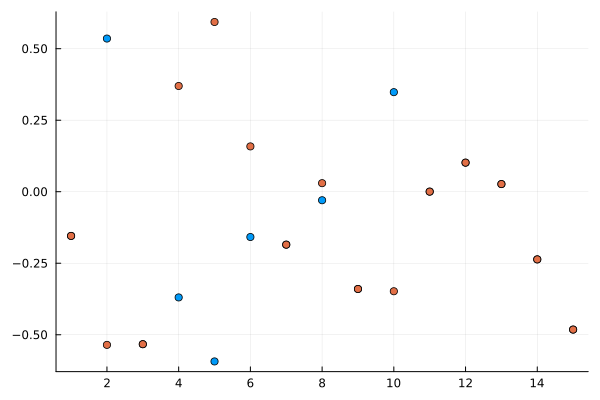

In [103]:
scatter(disLoops_y0[1:15, 1])
scatter!(Loops_y0[1:15, 1]; legend = false)

In [104]:
function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)